# Dataset Storage & Loading Issue

`.nifti` files usually takes much more space and time to load on the RAM. I have used `.h5` format to save the 3D brain scans with gut instinct. There is need to compare other possible formats, in terms of following:
- Saving time & Storage issue
- Loading time
- Precisions

Extensions to discuss:
- `.h5`
- `.npz`
- `.npy`
- `.nii.gz`

In [1]:
import os
from pathlib import Path
import random
import h5py
import shutil
import subprocess

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd

from sage.data.dataloader import open_h5_nifti, open_h5
import sage.constants as C

In [2]:
root = Path("./biobank")
files = sorted(root.rglob("*.h5"))

sample_fnames = random.choices(population=files, k=20)
sample_niftis = [(f, open_h5_nifti(f)) for f in sample_fnames]

In [3]:
tmp_root = Path("./tmp_data")
os.makedirs(tmp_root, exist_ok=True)

_dirs = ["nifti", "npz", "npy", "h5"]
dirs = {}
for _dir in _dirs:
    _d = tmp_root / _dir
    if _d.exists():
        shutil.rmtree(_d)
    os.makedirs(_d)
    dirs[_dir] = _d

## 1. Saving Time

Saving time from nifti to `.npy` and `.npz`

In [4]:
def save_npy(fname, nifti_obj, _dir):
    arr = nifti_obj.get_fdata()
    np.save(file=_dir / f"{fname.stem}.npy", arr=arr.astype(int))

def save_npz(fname, nifti_obj, _dir):
    arr = nifti_obj.get_fdata()
    np.savez_compressed(file=_dir / f"{fname.stem}.npz", arr=arr.astype(int))
    
def save_h5(fname, nifti_obj, _dir):
    """ Wtihout saving meta """
    arr = nifti_obj.get_fdata()
    with h5py.File(_dir / f"{fname.stem}.h5", mode="w", libver="latest") as hf:
        hf.create_dataset(name="volume", data=arr, compression="gzip", compression_opts=1, shuffle=True)
        
def save_nifti(fname, nifti_obj, _dir):
    arr = nifti_obj.get_fdata()
    nii = nib.nifti1.Nifti1Image(dataobj=arr, affine=C.BIOBANK_AFFINE)
    nib.save(img=nii, filename=_dir / f"{fname.stem}.nii.gz")

    
def save_surrogate(func, sample_niftis, _dir):
    for fname, nifti_obj in sample_niftis:
        func(fname=fname, nifti_obj=nifti_obj, _dir=_dir)

In [5]:
save_result, save_perf = dict(), dict()
for extension, _dir in dirs.items():
    print(extension, end="\t")
    func = eval(f"save_{extension}")
    timer = %timeit -o -r 5 save_surrogate(func=func, sample_niftis=sample_niftis, _dir=_dir)
    save_result[extension] = timer
    save_perf[extension] = timer.timings
save_perf = pd.DataFrame(save_perf)

nifti	6.91 s ± 164 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
npz	19.7 s ± 48.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
npy	1.12 s ± 21.1 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
h5	4.64 s ± 17.8 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [6]:
output = subprocess.check_output(args=f"cd {tmp_root} && ls | xargs du -sh",
                                 shell=True, text=True)

storage_dict = dict()
for val in output.strip().split("\n"):
    storage, ext = val.split("\t")
    storage_dict[ext] = storage
storage_dict

{'h5': '65M', 'nifti': '91M', 'npy': '1.1G', 'npz': '77M'}

## 2. Loading time & Precision

If saved data is well stored.

### 2.1 Check Loading Time

In [7]:
def load_npy(fname, _dir):
    arr = np.load(file=_dir / f"{fname.stem}.npy")
    return arr

def load_npz(fname, _dir):
    arr = np.load(file=_dir / f"{fname.stem}.npz")["arr"]
    return arr
    
def load_h5(fname, _dir):
    arr = open_h5(_dir / f"{fname.stem}.h5")
    return arr
        
def load_nifti(fname, _dir):
    nii = nib.nifti1.load(_dir / f"{fname.stem}.nii.gz")
    return nii.get_fdata()

def load_surrogate(func, sample_niftis, _dir):
    for fname, _ in sample_niftis:
        func(fname=fname, _dir=_dir)

In [8]:
load_result, load_perf = dict(), dict()
for extension, _dir in dirs.items():
    print(extension, end="\t")
    func = eval(f"load_{extension}")
    timer = %timeit -o -r 5 load_surrogate(func=func, sample_niftis=sample_niftis, _dir=_dir)
    load_result[extension] = timer
    load_perf[extension] = timer.timings
load_perf = pd.DataFrame(load_perf)

nifti	

2.68 s ± 6.46 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
npz	3.1 s ± 1.51 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
npy	269 ms ± 17 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
h5	2.79 s ± 1.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


### 2.2 Check if data is well stored.

In [9]:
def compare_npy(fname, _dir, nifti_obj):
    orig = nifti_obj.get_fdata()
    arr = np.load(file=_dir / f"{fname.stem}.npy")
    same = np.array_equal(orig, arr)
    return same

def compare_npz(fname, _dir, nifti_obj):
    orig = nifti_obj.get_fdata()
    arr = np.load(file=_dir / f"{fname.stem}.npz")["arr"]
    same = np.array_equal(orig, arr)
    return same
    
def compare_h5(fname, _dir, nifti_obj):
    orig = nifti_obj.get_fdata()
    arr, meta = open_h5(_dir / f"{fname.stem}.h5")
    same = np.array_equal(orig, arr)
    return same
        
def compare_nifti(fname, _dir, nifti_obj):
    orig = nifti_obj.get_fdata()
    nii = nib.nifti1.load(_dir / f"{fname.stem}.nii.gz")
    arr = nii.get_fdata()
    same = np.array_equal(orig, arr)
    return same

In [10]:
for extension, _dir in dirs.items():
    cumsum = 0
    for fname, nifti in sample_niftis:
        cumsum += eval(f"compare_{extension}(fname=fname, _dir=_dir, nifti_obj=nifti)")
    print(f"{extension}: {cumsum}")

nifti: 20
npz: 20
npy: 20
h5: 20


## 3. Conclusion

In [11]:
save_avg = {k: v.average for k, v in save_result.items()}
load_avg = {k: v.average for k, v in load_result.items()}

perf = pd.DataFrame([save_avg, load_avg, storage_dict], index=["Saving Time (sec)", "Loading Time (sec)", "Storage"]).T
perf.reset_index(inplace=True, drop=False)
perf.rename(mapper={"index": "Extension"}, inplace=True, axis=1)
perf.Storage = perf.Storage.apply(lambda x: float(x[:-1]) * 102 if x.endswith("G") else float(x[:-1]))
perf

,Extension,Saving Time (sec),Loading Time (sec),Storage
0,nifti,6.910531,2.684554,91.0
1,npz,19.672014,3.096104,77.0
2,npy,1.119445,0.268571,112.2
3,h5,4.642194,2.791049,65.0


/tmp/ipykernel_1345621/3511646487.py:8: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[idx]._sizes = [perf.Storage.iloc[idx - 1] * 0.9]
/tmp/ipykernel_1345621/3511646487.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[idx].set_visible(False)


Text(0.5, 1.0, 'Brain Scan Saving Format Comparison')

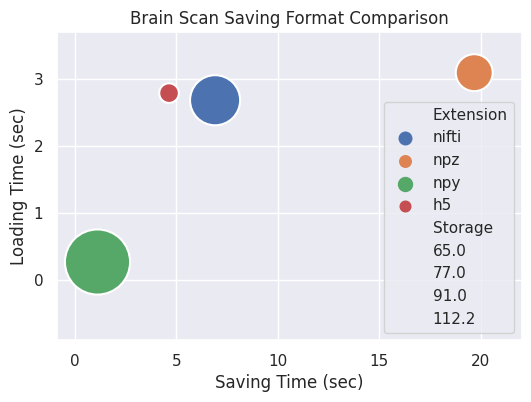

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=perf, x="Saving Time (sec)", y="Loading Time (sec)", hue="Extension",
                ax=ax, size="Storage", sizes=(200, 2200));
ax.set_xlim([-0.9, 22])
ax.set_ylim([-0.9, 3.7])
leg = ax.legend()
for idx in range(1, 5):
    leg.legendHandles[idx]._sizes = [perf.Storage.iloc[idx - 1] * 0.9]
for idx in range(5, 10):
    leg.legendHandles[idx].set_visible(False)

ax.set_title("Brain Scan Saving Format Comparison")

`.h5`가 제일 합리적인 것으로마무리.

# DataLoader speed comparison

`.npy`로 변경은 다했는데 lightning에서 속도가 너무 느려서 실제로 시간 비교해보기

`.h5`와 `.npy` 둘 다 HDD에 박혀잇는데 시간차이가 왜 많이 나는지 알 수 없음.

In [1]:
%cd ..
from torch.utils.data import DataLoader

from sage.data.dataloader import UKBDataset

h5_ds = UKBDataset(mode="test",)
npy_ds = UKBDataset(root="/home/data/hdd01/biobank_npy", mode="test", extension=".npy")

h5_dl = DataLoader(h5_ds, batch_size=32, shuffle=True, num_workers=8)
npy_dl = DataLoader(npy_ds, batch_size=32, shuffle=True, num_workers=8)

/home/1phantasmas/.conda/envs/age/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/1phantasmas/brain-age-prediction


INFO:sage.data.dataloader:Setting up UKBiobank Dataset
INFO:sage.data.dataloader:No exclusion file found. biobank/exclusion.csv
INFO:sage.data.dataloader:Total 3029 files of test .h5 exist
INFO:sage.data.dataloader:Setting up UKBiobank Dataset
INFO:sage.data.dataloader:No exclusion file found. /home/data/hdd01/biobank_npy/exclusion.csv
INFO:sage.data.dataloader:Total 3029 files of test .npy exist


In [2]:
stop_idx = 10

In [3]:
%%timeit
for idx, batch in enumerate(h5_dl):
    batch_ = batch
    if idx == stop_idx:
        break

23.3 s ± 3.41 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
from pathlib import Path
import random

selected_npy = random.choices(population=h5_ds.files, k=320)
selected_npy = ["biobank_npy" / Path(f"{f.stem}.npy") for f in selected_npy]
sum(p.exists() for p in selected_npy)

320

In [12]:
import subprocess
from tqdm import tqdm

# for npy in tqdm(selected_npy):
#     subprocess.run(["cp", npy, f"/home/data/hdd01/tmp_npy/{npy.stem}.npy"])

100%|██████████| 320/320 [01:31<00:00,  3.50it/s]


In [3]:
hdd01_npy_ds = UKBDataset(root="/home/data/hdd01/tmp_npy", mode="test", extension=".npy")
hdd01_npy_dl_nw0 = DataLoader(hdd01_npy_ds, batch_size=32, shuffle=True, num_workers=0)
hdd01_npy_dl_nw4 = DataLoader(hdd01_npy_ds, batch_size=32, shuffle=True, num_workers=4)
hdd01_npy_dl_nw8 = DataLoader(hdd01_npy_ds, batch_size=32, shuffle=True, num_workers=8)

INFO:sage.data.dataloader:Setting up UKBiobank Dataset
INFO:sage.data.dataloader:No exclusion file found. /home/data/hdd01/tmp_npy/exclusion.csv
INFO:sage.data.dataloader:Total 306 files of test .npy exist


In [4]:
%timeit hdd01_npy_ds[0]

The slowest run took 244.79 times longer than the fastest. This could mean that an intermediate result is being cached.
842 ms ± 1.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
ssd_npy_ds = UKBDataset(root="tmp_npy", mode="test", extension=".npy")
ssd_npy_dl_nw0 = DataLoader(ssd_npy_ds, batch_size=32, shuffle=True, num_workers=0)
ssd_npy_dl_nw4 = DataLoader(ssd_npy_ds, batch_size=32, shuffle=True, num_workers=4)
ssd_npy_dl_nw8 = DataLoader(ssd_npy_ds, batch_size=32, shuffle=True, num_workers=8)

INFO:sage.data.dataloader:Setting up UKBiobank Dataset
INFO:sage.data.dataloader:No exclusion file found. tmp_npy/exclusion.csv
INFO:sage.data.dataloader:Total 306 files of test .npy exist


In [7]:
%timeit ssd_npy_ds[0]

21.6 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
hdd03_npy_ds = UKBDataset(root="/home/data/hdd03/tmp_npy", mode="test", extension=".npy")
hdd03_npy_dl_nw0 = DataLoader(hdd03_npy_ds, batch_size=32, shuffle=True, num_workers=0)
hdd03_npy_dl_nw4 = DataLoader(hdd03_npy_ds, batch_size=32, shuffle=True, num_workers=4)
hdd03_npy_dl_nw8 = DataLoader(hdd03_npy_ds, batch_size=32, shuffle=True, num_workers=8)

INFO:sage.data.dataloader:Setting up UKBiobank Dataset
INFO:sage.data.dataloader:No exclusion file found. /home/data/hdd03/tmp_npy/exclusion.csv
INFO:sage.data.dataloader:Total 306 files of test .npy exist


In [16]:
%timeit hdd03_npy_ds[0]

21.7 ms ± 3.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
stop_idx = 5

In [9]:
%%timeit
for idx, batch in enumerate(hdd01_npy_dl_nw0):
    batch_ = batch
    if idx == stop_idx:
        break

The slowest run took 4.13 times longer than the fastest. This could mean that an intermediate result is being cached.
10.3 s ± 5.71 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
for idx, batch in enumerate(hdd01_npy_dl_nw4):
    batch_ = batch
    if idx == stop_idx:
        break

6.69 s ± 712 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
for idx, batch in enumerate(hdd01_npy_dl_nw8):
    batch_ = batch
    if idx == stop_idx:
        break

5.81 s ± 423 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
for idx, batch in enumerate(ssd_npy_dl_nw0):
    batch_ = batch
    if idx == stop_idx:
        break

5.94 s ± 336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
for idx, batch in enumerate(ssd_npy_dl_nw4):
    batch_ = batch
    if idx == stop_idx:
        break

7.57 s ± 349 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
for idx, batch in enumerate(ssd_npy_dl_nw8):
    batch_ = batch
    if idx == stop_idx:
        break

5.97 s ± 405 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
for idx, batch in enumerate(hdd03_npy_dl_nw0):
    batch_ = batch
    if idx == stop_idx:
        break

20.7 s ± 5.73 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit
for idx, batch in enumerate(hdd03_npy_dl_nw4):
    batch_ = batch
    if idx == stop_idx:
        break

8.04 s ± 561 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit
for idx, batch in enumerate(hdd03_npy_dl_nw8):
    batch_ = batch
    if idx == stop_idx:
        break

The slowest run took 7.33 times longer than the fastest. This could mean that an intermediate result is being cached.
17.2 s ± 12.6 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
